This notebook is designed for preprocessing the CRIME, LAR datasets, training XGB on CRIME, generating predictions, and creating spatial partitionings. 

The paths to the neccessary read/write folders are set to the below values:

**Paths**
* base_path: The main directory where all dataset-related files are stored. The default value is *../data/*
* datasets_base_path: Path where the raw datasets are stored. The default value is *base_path/datasets/*
* predictions_base_path: Path where base model predictions are saved. The default value is *base_path/predictions/*
* preprocess_path: Path where true labels are stored. The default value is *base_path/preprocess/*
* clf_base_path: Path where trained machine learning models are saved. The default value is *base_path/clf/*
* partioning_base_path: Path where partitioning results are saved. The default value is *base_path/partitionings/*
* crime_data_filename: The path to the crime dataset. The default value is *base_path/datasets/Crime_Data_from_2010_to_2019.csv.*
* lar_data_filename: The path to the crime dataset. The default value is *base_path/datasets/B4TYDEB6GKMZO031MB27_header.csv.*
* census_gazetteer_data_filename: The path to the crime dataset. The default value is *base_path/datasets/2021_Gaz_tracts_national.txt.*

**Produced Filenames Interpretation**
* partitionings: \<set name>\_regions_\<partitioning name>_\<dataset name>.csv.
* partitionings_ids: \<set name>\_regions_\<partitioning name>_\<dataset name>_ids.csv: same audit regions with partitionings in format where each id refers to a partitioning.
* predictions: \<set_name>_pred_<clf_name>_\<dataset>
where:

* \<set name>: train/val/set
* \<partitioning name>: 
    * 5_x_5 (ovelapping partitionings with max 5 row and max 5 columns i.e. 24 partitionings in toal excluding the 1x1), 
    * non_overlap_k_\<n\_regions> (non-overlapping regions produced by KMeans with <n\_regions> centers), 
    * overlap_k_\<n\_regions>\_radii_\<n_radii> (overlapping regions starting from <n\_regions> centers defined by KMeans and defing regions with max radius-boarders defined by the <n_radii> total radii).
* \<dataset name>: crime/lar
* \<clf_name>: xgb/dnn/semi\_synthetic\_regions_\<partitioning_name> (the dnn is trained and saved in the src/experiments/dnn_exp.ipynb)

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..")))

import numpy as np
from utils.xgb_crime import crime_xgb_train_predict
from utils.preprocess import proprocess_crime, preprocess_lar
from utils.create_partitioning import create_kmeans_partioning, create_grid_partitioning
from utils.create_unfair_world import create_unfair_world
from utils.results_names_utils import combine_world_info, get_train_val_test_paths
import zipfile

from tensorflow.keras import Sequential
import tensorflow as tf

import random
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import f1_score
import pandas as pd
from tensorflow.keras import backend as K

In [12]:
base_path = "../../data/"
datasets_base_path = f"{base_path}datasets/"
preprocess_base_path = f"{base_path}preprocess/"
predictions_base_path = f"{base_path}predictions/"
clf_base_path = f"{base_path}clf/"
partioning_base_path = f"{base_path}partitionings/"
crime_data_filename = f"{datasets_base_path}Crime_Data_from_2010_to_2019.csv"
lar_data_filename = f"{datasets_base_path}B4TYDEB6GKMZO031MB27_header.csv"
census_gazetteer_data_filename = f"{datasets_base_path}2021_Gaz_tracts_national.txt"
datasets_zip_fname = f"{datasets_base_path}datasets.zip"
datasets_extract_path = f"{datasets_base_path}"

for dir in [datasets_base_path, predictions_base_path, clf_base_path, partioning_base_path, preprocess_base_path]:
    os.makedirs(dir, exist_ok=True)

### Unzip datasets files

In [13]:
if os.path.exists(datasets_zip_fname):
    with zipfile.ZipFile(datasets_zip_fname, 'r') as zip_ref:
        zip_ref.extractall(datasets_extract_path)
    print("All files extracted successfully.")
else:
    print(f"File {datasets_zip_fname} does not exist!")

All files extracted successfully.


### Set - Combine the neccessary paths, labels descriptions

In [14]:
crime_dataset_name = "crime"
lar_dataset_name = "lar"

crime_xgb_clf_name = "xgb_crime"
crime_xgb_predictions_name = f"pred_{crime_xgb_clf_name}"
crime_xgb_train_predictions_filename = f"{predictions_base_path}train_{crime_xgb_predictions_name}.csv"
crime_xgb_val_predictions_filename = f"{predictions_base_path}val_{crime_xgb_predictions_name}.csv"
crime_xgb_test_predictions_filename = f"{predictions_base_path}test_{crime_xgb_predictions_name}.csv"
clf_xgb_filename = f"{clf_base_path}{crime_xgb_clf_name}.joblib"

lar_labels_filename = f"{preprocess_base_path}lar.csv"

crime_dnn_clf_name = "dnn_crime"
crime_dnn_predictions_name = f"pred_{crime_dnn_clf_name}"
crime_dnn_train_predictions_filename = f"{predictions_base_path}train_{crime_dnn_predictions_name}.csv"
crime_dnn_val_predictions_filename = f"{predictions_base_path}val_{crime_dnn_predictions_name}.csv"
crime_dnn_test_predictions_filename = f"{predictions_base_path}test_{crime_dnn_predictions_name}.csv"

### Preprocessing and Model Training

In [15]:
lar_df = preprocess_lar(lar_data_filename, census_gazetteer_data_filename, preprocess_base_path)
print(f"LAR total rows: {lar_df.shape[0]}")
print(f"LAR total positive rows: {lar_df['label'].sum()}")
lar_pr = lar_df['label'].sum() / lar_df.shape[0]
print(f"LAR positive rate: {lar_pr:.2f}")
display(lar_df.head())

/Users/dimitriskyriakopoulos/Documents/ath/AIDAPT/tool/promis-spatial-bias-mitigation/src/utils/preprocess.py:170: DtypeWarning: Columns (73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(lar_data_filename, delimiter="|")


LAR total rows: 206418
LAR total positive rows: 127286
LAR positive rate: 0.62


,label,lat,lon
0,1,39.707050,-75.583242
3,1,33.850356,-117.912135
5,1,42.101448,-83.160279
9,1,41.355900,-72.932356
10,0,40.715907,-73.982094


In [16]:
X_train_crime, X_val_crime, X_test_crime, y_train_crime, y_val_crime, y_test_crime = proprocess_crime(crime_data_filename, preprocess_base_path)

crime_total_positives =  y_train_crime.sum() + y_val_crime.sum() + y_test_crime.sum() 
crime_total_rows = y_train_crime.shape[0] + y_val_crime.shape[0] + y_test_crime.shape[0]
crime_total_pr = crime_total_positives / crime_total_rows

print(f"Crime total rows: {crime_total_rows}")
print(f"Crime total positives: {crime_total_positives}")
print(f"Crime total (true) positive rate: {crime_total_pr:.2f}")

print(f"X_train_crime.shape: {X_train_crime.shape}")
print(f"X_val_crime.shape: {X_val_crime.shape}")
print(f"X_test_crime.shape: {X_test_crime.shape}")
print(f"y_train_crime.shape: {y_train_crime.shape}")
print(f"y_val_crime.shape: {y_val_crime.shape}")
print(f"y_test_crime.shape: {y_test_crime.shape}")

display(X_train_crime.head())


Train size: 427922 (60.00%)
Validation size: 142641 (20.00%)
Test size: 142641 (20.00%)
Crime total rows: 713204
Crime total positives: 204204
Crime total (true) positive rate: 0.29
X_train_crime.shape: (427922, 49)
X_val_crime.shape: (142641, 49)
X_test_crime.shape: (142641, 49)
y_train_crime.shape: (427922,)
y_val_crime.shape: (142641,)
y_test_crime.shape: (142641,)


,TIME OCC,LAT,LON,Area_1,Area_2,Area_3,Area_4,Area_5,Area_6,Area_7,...,Descent_K,Descent_L,Descent_O,Descent_P,Descent_S,Descent_U,Descent_V,Descent_W,Descent_X,Descent_Z
0,130,34.0229,-118.2216,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,33.9527,-118.3090,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1615,34.0812,-118.2032,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1100,34.2103,-118.4529,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1140,33.9933,-118.2871,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# This step trains XGBoost on the crime dataset and saves the pretrained model, its predictions and probabilities.
y_train_pred, y_test_pred, y_val_pred = crime_xgb_train_predict(
    X_train=X_train_crime,
    X_val=X_val_crime,
    X_test=X_test_crime,
    y_train=y_train_crime,
    crime_train_predictions_filename=crime_xgb_train_predictions_filename,
    crime_val_predictions_filename=crime_xgb_val_predictions_filename,
    crime_test_predictions_filename=crime_xgb_test_predictions_filename,
    clf_filename=clf_xgb_filename,
)

In [18]:
crime_y_train_pr = y_train_pred.sum() / y_train_pred.shape[0]
crime_y_val_pr = y_val_pred.sum() / y_val_pred.shape[0]
crime_y_test_pr = y_test_pred.sum() / y_test_pred.shape[0]
print(f"Positive rate in training predictions: {crime_y_train_pr:.2f}")
print(f"Positive rate in validation predictions: {crime_y_val_pr:.2f}")
print(f"Positive rate in test predictions: {crime_y_test_pr:.2f}")

crime_y_train_tpr = (y_train_pred & y_train_crime).sum() / y_train_crime.sum()
crime_y_val_tpr = (y_val_pred & y_val_crime).sum() / y_val_crime.sum()
crime_y_test_tpr = (y_test_pred & y_test_crime).sum() / y_test_crime.sum()
print(f"Crime true positive rate in training set: {crime_y_train_tpr:.2f}")
print(f"Crime true positive rate in validation set: {crime_y_val_tpr:.2f}")
print(f"Crime true positive rate in test set: {crime_y_test_tpr:.2f}")

crime_val_acc = (y_val_pred == y_val_crime).sum() / y_val_crime.shape[0]
crime_test_acc = (y_test_pred == y_test_crime).sum() / y_test_crime.shape[0]
print(f"Crime validation accuracy: {crime_val_acc:.2f}")
print(f"Crime test accuracy: {crime_test_acc:.2f}")

Positive rate in training predictions: 0.11
Positive rate in validation predictions: 0.11
Positive rate in test predictions: 0.11
Crime true positive rate in training set: 0.24
Crime true positive rate in validation set: 0.22
Crime true positive rate in test set: 0.22
Crime validation accuracy: 0.73
Crime test accuracy: 0.73


/Users/dimitriskyriakopoulos/Documents/ath/AIDAPT/tool/promis-spatial-bias-mitigation/src/promis-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         5,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,752 (42.00 KB)

 Trainable params: 10,452 (40.83 KB)

 Non-trainable params: 300 (1.17 KB)

None
Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5455 - loss: 0.6362 - val_accuracy: 0.2946 - val_loss: 0.7300
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5566 - loss: 0.6356 - val_accuracy: 0.4859 - val_loss: 0.6476
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5694 - loss: 0.6348 - val_accuracy: 0.6345 - val_loss: 0.6400
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5784 - loss: 0.6340 - val_accuracy: 0.6724 - val_loss: 0.6728
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5862 - loss: 0.6333 - val_accuracy: 0.6788 - val_loss: 0.6841
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5965 - loss: 0.6323 - val_accuracy: 0.6817 - val_loss: 0.6900
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6095 - loss: 0.6307 - val_accuracy: 0.6866 - val_loss: 0.6976
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6220 - loss: 0.62

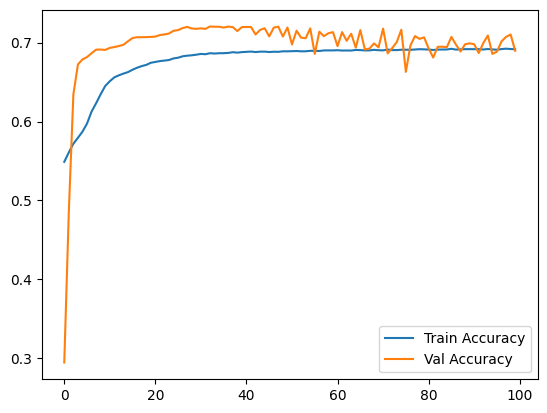

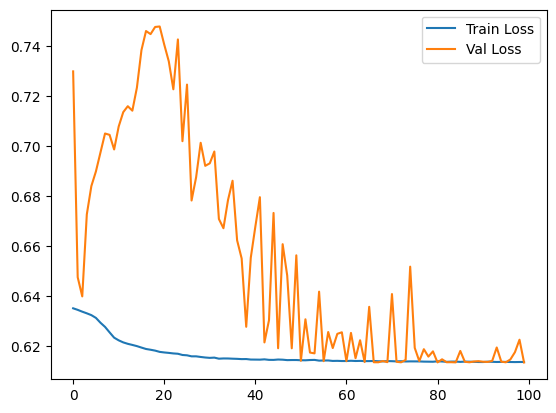

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1 train: 0.47959111237311, F1 val: 0.47990693739424706, F1 test: , 0.4782956874013708
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [19]:
# This step trains a DNN on the crime dataset and saves the predictions and probabilities.

def dice(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersect = tf.reduce_sum(y_pred * y_true, axis=0) + K.epsilon()
    denominator = tf.reduce_sum(y_pred, axis=0) + tf.reduce_sum(y_true, axis=0)
    dice_scores = 2 * intersect / (denominator + tf.keras.backend.epsilon())
    return 1 - dice_scores

def custom_loss(y_true, y_pred):
    loss = dice(y_true, y_pred)
    return loss

BATCH_SIZE = 64*64
LEARNING_RATE = 0.0001
LEARNING_RATE_INIT = LEARNING_RATE
EPOCH_TRAIN = 100

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

initializer = tf.keras.initializers.TruncatedNormal(stddev=0.5, seed=SEED)
base_model = Sequential([
    Dense(100, activation='elu', input_dim=X_train_crime.shape[1], kernel_initializer=initializer),
    BatchNormalization(),
    Dropout(0.1),
    Dense(50, activation='elu', kernel_initializer=initializer),
    BatchNormalization(),
    Dropout(0.1),
    Dense(2, activation='softmax', kernel_initializer=initializer),
])

print(base_model.summary())


optimizer = Adam(learning_rate=LEARNING_RATE)
base_model.compile(optimizer=optimizer, loss=custom_loss, metrics=['accuracy'])

# Start Training
history = base_model.fit(
    X_train_crime,
    y_train_crime,
    batch_size=BATCH_SIZE,
    epochs=EPOCH_TRAIN,
    shuffle=True,
    validation_data=(X_val_crime, y_val_crime),
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

#Predict the label
y_train_pred_base = base_model.predict(X_train_crime, batch_size=BATCH_SIZE)
y_val_pred_base =  base_model.predict(X_val_crime, batch_size=BATCH_SIZE)
y_test_pred_base =  base_model.predict(X_test_crime, batch_size=BATCH_SIZE)

#Change Softmax to class
class_y_train_pred_base = np.argmax(y_train_pred_base, axis=-1)
class_y_val_pred_base = np.argmax(y_val_pred_base, axis=-1)
class_y_test_pred_base = np.argmax(y_test_pred_base, axis=-1)

base_test_f1 = f1_score(y_test_crime,class_y_test_pred_base)

print(f"F1 train: {f1_score(y_train_crime,class_y_train_pred_base)}, F1 val: {f1_score(y_val_crime,class_y_val_pred_base)}, F1 test: , {f1_score(y_test_crime,class_y_test_pred_base)}")

pos_class_prob_idx = 1  # Positive class index

y_train_base_pred_proba = base_model.predict(X_train_crime, batch_size=BATCH_SIZE)[:, pos_class_prob_idx]
y_val_base_pred_proba = base_model.predict(X_val_crime, batch_size=BATCH_SIZE)[:, pos_class_prob_idx]
y_test_base_pred_proba = base_model.predict(X_test_crime, batch_size=BATCH_SIZE)[:, pos_class_prob_idx]

preds_df = pd.DataFrame({
    "pred": class_y_train_pred_base,
    "pred_proba": y_train_base_pred_proba,
})

val_preds_df = pd.DataFrame({
    "pred": class_y_val_pred_base,
    "prob": y_val_base_pred_proba
})

test_preds_df = pd.DataFrame({
    "pred": class_y_test_pred_base,
    "prob": y_test_base_pred_proba
})

preds_df.to_csv(crime_dnn_train_predictions_filename, index=False)
val_preds_df.to_csv(crime_dnn_val_predictions_filename, index=False)
test_preds_df.to_csv(crime_dnn_test_predictions_filename, index=False)

### Create Audit Regions

#### Creating Overlapping Partitioning

Divides the data into spatial clusters using the KMeans clustering method for the initial center and with increasing radii starting from each center generates overlapping clusters.

In [20]:
# Divides the crime data into spatial clusters 

overlapping = True
k = 10
radii = np.arange(0.01, 0.1, 0.03)
create_kmeans_partioning(
    train_with_loc_filename=crime_xgb_train_predictions_filename,
    val_with_loc_filename=crime_xgb_val_predictions_filename,
    test_with_loc_filename=crime_xgb_test_predictions_filename,
    partioning_base_path=partioning_base_path,
    dataset_name=crime_dataset_name,
    overlapping=overlapping,
    k=k,
    radii=radii,
    with_partitioning_id=True,
)

Total seeds: 10
Total radii: 4
Total regions created: 40
There are 1987 points that are not covered by the regions


Search for closest regions to assign uncovered points: 100%|██████████| 1987/1987 [02:02<00:00, 16.19it/s]
Adding uncovered points to regions: 1987it [01:09, 28.74it/s]


There are 0 points that are not covered by the regions
There are 0 points that are not covered by the regions
There are 0 points that are not covered by the regions of train set
There are 0 points that are not covered by the regions of val set
There are 0 points that are not covered by the regions of test set


'overlap_k_10_radii_4_crime'

In [21]:
# Divides the lar data into spatial clusters 

overlapping = True
k = 100
radii = np.arange(0.05, 1.51, 0.05)
create_kmeans_partioning(
    train_with_loc_filename=lar_labels_filename,
    partioning_base_path=partioning_base_path,
    dataset_name=lar_dataset_name,
    overlapping=overlapping,
    k=k,
    radii=radii,
)

Total seeds: 100
Total radii: 30
Total regions created: 3000
There are 2149 points that are not covered by the regions


Search for closest regions to assign uncovered points: 100%|██████████| 2149/2149 [02:15<00:00, 15.80it/s]
Adding uncovered points to regions: 2149it [01:16, 28.16it/s]


There are 0 points that are not covered by the regions
There are 0 points that are not covered by the regions
There are 0 points that are not covered by the regions of train set


'overlap_k_100_radii_30_lar'

#### Creating Non-Overlapping Partitioning

* overlapping=False to ensure that each data point belongs to only one region.
* Keep k=10 clusters.
* radii=None since overlapping is disabled.


In [22]:
# Divides the crime data into spatial non-overlapping clusters using the KMeans clustering method.
overlapping = False
k = 8
radii = None
create_kmeans_partioning(
    train_with_loc_filename=crime_xgb_train_predictions_filename,
    val_with_loc_filename=crime_xgb_val_predictions_filename,
    test_with_loc_filename=crime_xgb_test_predictions_filename,
    partioning_base_path=partioning_base_path,
    dataset_name=crime_dataset_name,
    overlapping=overlapping,
    k=k,
    radii=radii,
    with_partitioning_id=True,
)

Total regions created: 8
There are 0 points that are not covered by the regions


Search for closest regions to assign uncovered points: 0it [00:00, ?it/s]
Adding uncovered points to regions: 0it [00:00, ?it/s]

There are 0 points that are not covered by the regions


There are 0 points that are not covered by the regions
There are 0 points that are not covered by the regions of train set
There are 0 points that are not covered by the regions of val set
There are 0 points that are not covered by the regions of test set


'non_overlap_k_8_crime'

In [23]:
# Divides the lar data into spatial non-overlapping clusters using the KMeans clustering method.

overlapping = False
k = 100
radii = None
create_kmeans_partioning(
    train_with_loc_filename=lar_labels_filename,
    partioning_base_path=partioning_base_path,
    dataset_name=lar_dataset_name,
    overlapping=overlapping,
    k=k,
    radii=radii,
)

Total regions created: 100
There are 0 points that are not covered by the regions


Search for closest regions to assign uncovered points: 0it [00:00, ?it/s]
Adding uncovered points to regions: 0it [00:00, ?it/s]

There are 0 points that are not covered by the regions
There are 0 points that are not covered by the regions
There are 0 points that are not covered by the regions of train set


'non_overlap_k_100_lar'

#### Create Grid with max rowsXcolumns = 5X5

In [24]:
# Create partitionings with max 5X5 row and columns for CRIME
create_grid_partitioning(
    5,
    5,
    train_with_loc_filename=crime_xgb_train_predictions_filename,
    val_with_loc_filename=crime_xgb_val_predictions_filename,
    test_with_loc_filename=crime_xgb_test_predictions_filename,
    partitioning_dir=partioning_base_path,
    dataset_name=crime_dataset_name,
)

Train Boundary:  33.3427 34.7907 -118.7668 -117.7157
Val Boundary:  33.7058 34.5477 -118.6673 -117.7115
Test Boundary:  33.7062 34.634 -118.7668 -117.7528
Global Boundary:  33.3427 34.7907 -118.7668 -117.7115


In [25]:
# Create partitionings with max 5X5 row and columns for LAR
create_grid_partitioning(
    5,
    5,
    train_with_loc_filename=lar_labels_filename,
    partitioning_dir=partioning_base_path,
    dataset_name=lar_dataset_name,
)

Train Boundary:  19.5361762 64.8944045 -161.8508035 -67.1081422
Global Boundary:  19.5361762 64.8944045 -161.8508035 -67.1081422


### Create Crime Semi-Synthetic Datasets

#### Create Unfair By Design World Using Non-Overlapping Regions

In [26]:
clf_name, partioning_type_name, overlap =  "xgb", "non_overlap_k_8", False
res_desc_label, partioning_name, prediction_name = (
    combine_world_info(crime_dataset_name, partioning_type_name, clf_name)
)
_, _, test_path_info = get_train_val_test_paths(
    base_path, partioning_name, prediction_name, crime_dataset_name
)

create_unfair_world(
    rho=0.8,
    test_path_info=test_path_info,
    predictions_path=predictions_base_path,
    partioning_name=partioning_name,
)

Stats with generation of true types with binomial of rho 0.8 making the world unfair:
N=142641 points
P=114112 positives
Original SBI: 0.000
Significance threshold: 6.164
Total significant regions: 0




actual flips: 29610
pos2neg flips: 14805, neg2pos flips 14805, total: 29610
Unfair World SBI: 0.054
Significance threshold: 8.920
Total significant regions: 0


#### Create Unfair By Design World Using Overlapping Regions

In [27]:
clf_name, partioning_type_name, overlap =  "xgb", "overlap_k_10_radii_4", True
res_desc_label, partioning_name, prediction_name = (
    combine_world_info(crime_dataset_name, partioning_type_name, clf_name)
)
_, _, test_path_info = get_train_val_test_paths(
    base_path, partioning_name, prediction_name, crime_dataset_name
)

create_unfair_world(
    rho=0.8,
    test_path_info=test_path_info,
    predictions_path=predictions_base_path,
    partioning_name=partioning_name,
)

Stats with generation of true types with binomial of rho 0.8 making the world unfair:
N=142641 points
P=114112 positives
Original SBI: 0.000
Significance threshold: 8.147
Total significant regions: 0




















actual flips: 41422
pos2neg flips: 20711, neg2pos flips 20711, total: 41422
Unfair World SBI: 0.103
Significance threshold: 6.898
Total significant regions: 0


#### Create Unfair By Design World Using Grid with max rowsXcolumns = 5X5

In [28]:
clf_name, partioning_type_name, overlap =  "xgb", "5_x_5", True
res_desc_label, partioning_name, prediction_name = (
    combine_world_info(crime_dataset_name, partioning_type_name, clf_name)
)
_, _,  test_path_info = get_train_val_test_paths(
    base_path, partioning_name, prediction_name, crime_dataset_name
)

create_unfair_world(
    rho=0.8,
    test_path_info=test_path_info,
    predictions_path=predictions_base_path,
    partioning_name=partioning_name,
)

Stats with generation of true types with binomial of rho 0.8 making the world unfair:
N=142641 points
P=114112 positives
Original SBI: 0.000
Significance threshold: 8.706
Total significant regions: 0
















































































































actual flips: 45284
pos2neg flips: 22642, neg2pos flips 22642, total: 45284
Unfair World SBI: 0.045
Significance threshold: 5.978
Total significant regions: 0
